# Collaborative filtering

## Dependencies

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.decomposition import MiniBatchNMF
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import RandomizedSearchCV
import joblib


ratings = pd.read_csv("../data/movielens/ratings.csv", usecols=["user_id", "movie_id", "rating"])

## Preprocessing

In [6]:
n_users = ratings["user_id"].nunique()
n_movies = ratings["movie_id"].nunique()
n_ratings = ratings["rating"].shape[0]

print(f"There are {n_users} users in the dataset.")
print(f"There are {n_movies} movies in the dataset.")
print(f"There are {n_ratings} ratings in the dataset.")

There are 330975 users in the dataset.
There are 83239 movies in the dataset.
There are 33832162 ratings in the dataset.


### Filtering

#### Users

----USERS----
Average ratings per user: 102
Median ratings per user: 31
Min ratings: 1
25th quantile: 15
50th quantile: 31
75th quantile: 98
90th quantile: 250
95th quantile: 421
Max ratings: 33332


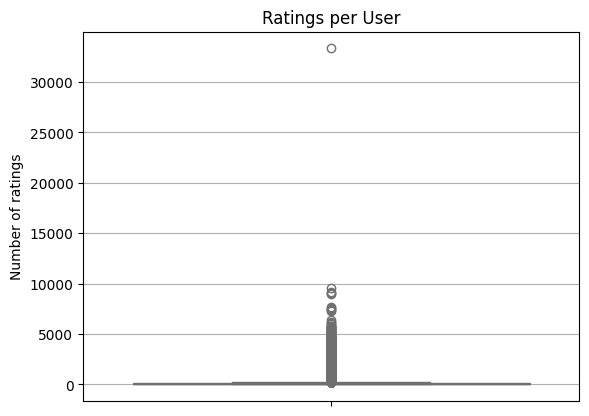

In [7]:
# Finding stats on user ratings
ratings_per_user = ratings.groupby("user_id").size()
print("----USERS----")
print(f"Average ratings per user: {ratings_per_user.mean():.0f}")
print(f"Median ratings per user: {ratings_per_user.median():.0f}")
print(f"Min ratings: {ratings_per_user.min()}")
print(f"25th quantile: {ratings_per_user.quantile(0.25):.0f}")
print(f"50th quantile: {ratings_per_user.quantile(0.5):.0f}")
print(f"75th quantile: {ratings_per_user.quantile(0.75):.0f}")
print(f"90th quantile: {ratings_per_user.quantile(0.9):.0f}")
print(f"95th quantile: {ratings_per_user.quantile(0.95):.0f}")
print(f"Max ratings: {ratings_per_user.max()}")

sns.boxplot(y=ratings_per_user, color="skyblue")
plt.title("Ratings per User")
plt.xlabel("")
plt.ylabel("Number of ratings")
plt.grid(axis="y")
plt.show()

In [8]:
# Filtering out users with few rating contributions
user_rating_counts = ratings["user_id"].value_counts()
filtered_users = user_rating_counts[user_rating_counts >= ratings_per_user.quantile(0.50)].index
filtered_ratings = ratings[ratings["user_id"].isin(filtered_users)]

# Calculate the number of ratings per user, then drop the users with fewer than cap and create a list of user_ids
user_cap = int(ratings_per_user.quantile(0.9))
user_whales_list = filtered_ratings.groupby("user_id")["rating"].size().apply(lambda x: x if x > user_cap else np.nan).dropna().index.tolist() # A whale is significantly larger than the average

# Iterate over each user and sample {user_cap} number of ratings
whales_collection = []
user_whales_df = filtered_ratings[filtered_ratings["user_id"].isin(user_whales_list)]
for user, user_df in user_whales_df.groupby("user_id"):
    rand_idxs = np.random.choice(user_df.shape[0], user_cap, replace=False)
    user_df_capped = user_df.iloc[rand_idxs]
    whales_collection.append(user_df_capped)
whales_capped = pd.concat(whales_collection)

# Remove whale data and insert the sampled whale data
filtered_ratings = filtered_ratings[filtered_ratings["user_id"].isin(user_whales_list) == False]
filtered_ratings = pd.concat([filtered_ratings, whales_capped], ignore_index=True)

#### Movies

In [9]:
# Finding stats on movie ratings (after filtering users)
ratings_per_movie = filtered_ratings.groupby("movie_id").size()
print("----MOVIES----")
print(f"Average ratings per movie: {ratings_per_movie.mean():.0f}")
print(f"Median ratings per movie: {ratings_per_movie.median():.0f}")
print(f"Min ratings: {ratings_per_movie.min()}")
print(f"25th quantile: {ratings_per_movie.quantile(0.25):.0f}")
print(f"50th quantile: {ratings_per_movie.quantile(0.5):.0f}")
print(f"75th quantile: {ratings_per_movie.quantile(0.75):.0f}")
print(f"90th quantile: {ratings_per_movie.quantile(0.9):.0f}")
print(f"95th quantile: {ratings_per_movie.quantile(0.95):.0f}")
print(f"Max ratings: {ratings_per_movie.max()}")

----MOVIES----
Average ratings per movie: 369
Median ratings per movie: 4
Min ratings: 1
25th quantile: 1
50th quantile: 4
75th quantile: 24
90th quantile: 287
95th quantile: 1143
Max ratings: 81924


In [10]:
# Filtering out movies with few ratings
movie_rating_counts = filtered_ratings["movie_id"].value_counts()
filtered_movies = movie_rating_counts[movie_rating_counts >= ratings_per_movie.quantile(0.75)].index
filtered_ratings = filtered_ratings[filtered_ratings["movie_id"].isin(filtered_movies)]

# Calculate the number of ratings per movie, then drop the movies with fewer than cap and create a list of movie_ids
movie_cap = int(ratings_per_movie.quantile(0.9))
movie_whales_list = filtered_ratings.groupby("movie_id")["rating"].size().apply(lambda x: x if x > movie_cap else np.nan).dropna().index.tolist()

# Iterate over each movie and sample {movie_cap} number of ratings
whales_collection = []
movie_whales_df = filtered_ratings[filtered_ratings["movie_id"].isin(movie_whales_list)]
for movie, movie_df in movie_whales_df.groupby("movie_id"):
    rand_idxs = np.random.choice(movie_df.shape[0], movie_cap, replace=False)
    movie_df_capped = movie_df.iloc[rand_idxs]
    whales_collection.append(movie_df_capped)
whales_capped = pd.concat(whales_collection)

# Remove whale data and insert the sampled whale data
filtered_ratings = filtered_ratings[filtered_ratings["movie_id"].isin(movie_whales_list) == False]
filtered_ratings = pd.concat([filtered_ratings, whales_capped], ignore_index=True)

In [11]:
# Reviewing the filtered dataset
n_users_filtered = filtered_ratings["user_id"].nunique()
n_movies_filtered = filtered_ratings["movie_id"].nunique()
n_ratings_filtered = filtered_ratings["rating"].shape[0]
print(f"There are now {n_users_filtered} users in the dataset. {n_users_filtered / n_users:.0%} of the original dataset.")
print(f"There are now {n_movies_filtered} movies in the dataset. {n_movies_filtered / n_movies:.0%} of the original dataset.")
print(f"There are now {n_ratings_filtered} ratings in the dataset. {n_ratings_filtered / n_ratings:.0%} of the original dataset.")

There are now 155287 users in the dataset. 47% of the original dataset.
There are now 14136 movies in the dataset. 17% of the original dataset.
There are now 2399676 ratings in the dataset. 7% of the original dataset.


In [12]:
# Returning the filtered dataset
ratings = filtered_ratings

### Scaling user ratings

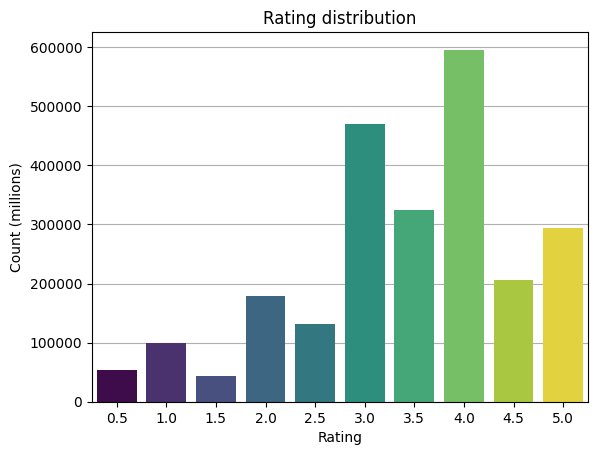

In [11]:
# Visualising the rating distribution
rating_distribution = ratings["rating"].value_counts().to_dict()
rating_distribution = dict(sorted(rating_distribution.items()))
sns.barplot(x=list(rating_distribution.keys()), y=list(rating_distribution.values()), hue=list(rating_distribution.keys()), palette="viridis", legend=False, zorder=2)
plt.xlabel("Rating")
plt.ylabel("Count (millions)")
plt.title("Rating distribution")
plt.grid(axis="y")
plt.show()

In [13]:
def scaler(df):
    """
    Scales (standardising and normalising) the ratings of each user. 
    Standardising is necessary since the ratings overall are not normally distributed 
    and some users might always rate high, low or with a large variance. 
    Normalising is necessary since matrix factorisation can only handle non-negative values.

    Arguments:
    df -- DataFrame with user_id, movie_id and rating columns

    Returns:
    df -- DataFrame with user_id, movie_id and scaled rating columns
    """
    df_collection = []
    for user, user_df in df.groupby("user_id"): 
        rating_values = user_df["rating"].values
        mean = np.mean(rating_values)
        std = np.std(rating_values)
        if std < 1e-10:
            user_df["rating"]=0.5 # if std is 0, set rating to 0.5 which is an average rating once ratings are normalised (0 to 1)
        else:
            std_values = (rating_values - mean) / std
            min_std = np.min(std_values)
            max_std = np.max(std_values)
            user_df["rating"] = (std_values - min_std) / (max_std - min_std)
        df_collection.append(user_df) # stores dataframes in a list which are concatenated at the end
    return pd.concat(df_collection)


scaled_ratings = ratings.copy()
scaled_ratings = scaler(scaled_ratings)

In [14]:
scaled_ratings.head(2)

,user_id,movie_id,rating
0,1,7122,1.0
1065517,1,1396,0.0


In [15]:
ratings = scaled_ratings

### User-movie matrix

In [16]:
# Creating a user-movie matrix using pivot_table() crashes the kernel. 
# I tried creating a sparse matrix (see line below) with user_id, movie_id and rating as rows, columns and values but that resulted in a much larger matrix than users * movies. 
# sparse_matrix = coo_matrix((ratings["rating"], (ratings["user_id"], ratings["movie_id"])))
# From my understanding the issue is that the IDs are not contiguous (0, 1, 2, 3 ...) resulting in a shape of max_user_ID * max_movie_ID.
# I asked Claude Sonnet 3.7 to: "Modify the code to create a sparse matrix in the shape of users*movies."

# Get unique user and movie IDs
unique_users = np.sort(ratings["user_id"].unique())
unique_movies = np.sort(ratings["movie_id"].unique())

# Create mappings from original IDs to consecutive indices
user_mapper = {user: i for i, user in enumerate(unique_users)}
movie_mapper = {movie: i for i, movie in enumerate(unique_movies)}

# Recovering the original user and movie IDs
user_mapper_reverse = {i: user for i, user in enumerate(unique_users)}
movie_mapper_reverse = {i: movie for i, movie in enumerate(unique_movies)}

# Map original IDs to indices
rows = np.array([user_mapper[user] for user in ratings["user_id"]])
cols = np.array([movie_mapper[movie] for movie in ratings["movie_id"]])
vals = ratings["rating"].values

# Create the sparse matrix with appropriate shape
rating_matrix = csr_matrix((vals, (rows, cols)), shape=(len(unique_users), len(unique_movies)))

In [17]:
density = rating_matrix.nnz / (rating_matrix.shape[0] * rating_matrix.shape[1])
print(f"Only {density * 100:.3f} % of the matrix contains ratings.") 

Only 0.109 % of the matrix contains ratings.


In [17]:
rating_matrix.shape

(155312, 14156)

## Matrix factorisation

### Find the optimal regularisation value

In [ ]:
from scipy.stats import uniform, loguniform

# Using a random sample size instead of the whole matrix to increase performance
sample_size = 1000
sample_users = np.random.choice(rating_matrix.shape[0], sample_size, replace=False)
sample_movies = np.random.choice(rating_matrix.shape[1], sample_size, replace=False)
sample_matrix = rating_matrix[sample_users, :][:, sample_movies]

model = MiniBatchNMF()
params = {
    "alpha_H": loguniform(1e-4, 1),
    "alpha_W": loguniform(1e-4, 1),
    "l1_ratio": uniform(0, 1),
}

rand_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=params,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)
rand_search.fit(sample_matrix)
print(f"Best parameters: {rand_search.best_params_}")

### Find the optimal rank

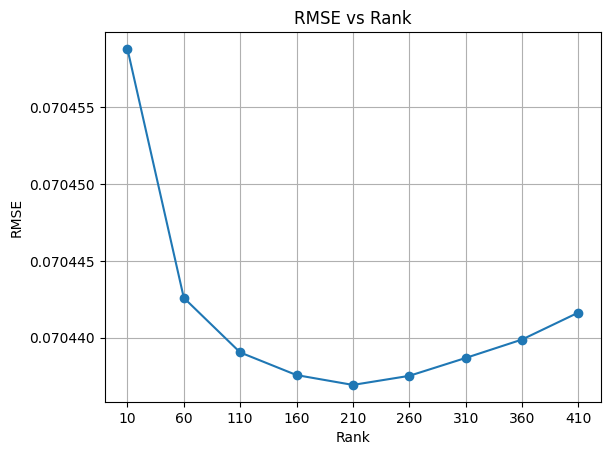

In [21]:
rank_range = range(10, 411, 50)
b = 5000
sample_size = 1000
RMSE_values = []
sample_users = np.random.choice(rating_matrix.shape[0], sample_size, replace=False)
sample_movies = np.random.choice(rating_matrix.shape[1], sample_size, replace=False)

for n in rank_range:
    model = MiniBatchNMF(
        n_components=n,
        batch_size=b,
        l1_ratio=rand_search.best_params_["l1_ratio"],
        alpha_H=rand_search.best_params_["alpha_H"],
        alpha_W=rand_search.best_params_["alpha_W"]
    )
    W = model.fit_transform(rating_matrix)
    H = model.components_
    V = np.dot(W[sample_users, :], H[:, sample_movies])
    R = rating_matrix[sample_users, :][:, sample_movies].toarray()
    RMSE = np.sqrt(mean_squared_error(R, V))
    RMSE_values.append(RMSE)

plt.plot(rank_range, RMSE_values, marker="o")
plt.xlabel("Rank")
plt.ylabel("RMSE")
plt.title("RMSE vs Rank")
plt.xticks(rank_range)
plt.grid()
plt.show()

### MBNMF model

In [18]:
n = 35 # 200 tog 10 min, 400 tog 30 min (laptop)

nmf = MiniBatchNMF(n_components=150, batch_size=5000, alpha_W=0.001, alpha_H=0.01, l1_ratio=0.65)
W = nmf.fit_transform(rating_matrix)    # W = latent user factors
H = nmf.components_                     # H = latent movie factors
print(f"Shape of W: {W.shape}")
print(f"Shape of H: {H.shape}")

Shape of W: (155287, 150)
Shape of H: (150, 14136)


## Movie data

In [19]:
movies = pd.read_csv("../data/movielens/movies.csv")

In [20]:
movies.shape

(86537, 3)

In [21]:
movies = movies.drop(columns="genres")
movies = movies[movies["movie_id"].isin(ratings["movie_id"].unique())]

In [22]:
movies.shape

(14136, 2)

## Recommendations

In [23]:
pix = [152081, 134853, 6377]          # Zootopia, Inside Out, Finding Nemo
mix = [1, 79132, 171011]              # Toy Story, Inception, Planet Earth II

In [ ]:
input_movies = mix
n_recs = 10

input_indices = [movie_mapper[movie] for movie in input_movies]
input_matrix = H[:, input_indices].transpose()  # shape: (n_input_movies, n_factors)
similarity_scores = cosine_similarity(input_matrix, H.T)  # shape: (n_input_movies, n_all_movies)

# Find the highest similarity score for each candidate movie
similarity_scores = np.max(similarity_scores, axis=0)  # shape: (n_all_movies, )
similarity_scores[input_indices] = 0

# Sort the scores without affecting the order
sorted_scores = np.sort(similarity_scores)[::-1]
sorted_indices = np.argsort(similarity_scores)[::-1]
sorted_movies = [movie_mapper_reverse[idx] for idx in sorted_indices]

# Create a DataFrame with the top recommendations
movie_titles = [title for id in sorted_movies[:n_recs] for title in movies[movies["movie_id"] == id]["title"].values]
top_movies = [(movie, title, score) for movie, title, score in zip(sorted_movies, movie_titles, sorted_scores)][:n_recs]
top_df = pd.DataFrame(top_movies, columns=["movie_id", "title", "score"])
top_df = top_df.sort_values("score", ascending=False)



# np.max() = recommends movies similar to any of the input movies

,movie_id,title,score
0,179135,Blue Planet II (2017),0.774327
1,159817,Planet Earth (2006),0.773914
2,142115,The Blue Planet (2001),0.746921
3,100044,Human Planet (2011),0.736400
4,106489,"Hobbit: The Desolation of Smaug, The (2013)",0.618579
5,59846,"Iron Mask, The (1929)",0.615254
6,97752,Cloud Atlas (2012),0.613551
7,106696,Frozen (2013),0.605933
8,77846,12 Angry Men (1997),0.603642
9,81591,Black Swan (2010),0.602716
